In [1]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
#The spacetime parameters. Let the population distribution of gene expression level be g:
g_min = 0
g_max = 100
dg = 0.4
#Defining a g_ghost which contains two extra `ghost' points at the edges:
g_ghost = np.arange(g_min-dg,g_max+2*dg,dg)
g = np.array(g_ghost[1:-1])


#Time:
dt = 0.00008
T = 20
# Nt = int(T/dt)
TimeRange = np.arange(0,T+dt,dt)

#How the population distributions evolve in the absence of selection. First, we define the free parameters...
#...K and alpha, and from those D. K sets the timescale of population response to the regulated mean...
#...which is set instantaneously. We may choose time units such that K=1.
K = 1
#The strength of noise:
alpha = 5
#The spread, with the preferred expression level (peak) now set to 50% of maximum.:
g_peak = 0.5*(g_min+g_max)
D = alpha*K*g_max

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")
    
#Now let's add selection to the picture. First, defining the relative differential growth rate delta.
delta = .17/g_max

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

K = 1; 0.5*dg/dt = 2500.0
D = 500; 0.5*dg**2/dt = 1000.0000000000001


In [9]:
#First derivative, central difference method (used in the potential term K*d/dg (g*P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv1(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    #Below we calculate the first derivative using the central difference method:
    derivative = (func_right - func_left)/(2*dx)
    return derivative

#Second derivative using central difference, used in the diffusion term (D*d2/dg2 (P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv2(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    func_center = func[1:-1]
    #Below we calculate the second derivative, again using central difference method:
    derivative2 = (func_right + func_left - 2*func_center)/(dx**2)
    return derivative2

#Defining a Gaussian pdf - we'll need it for P(g,t=0), the initial distribution:
@jit(nopython=True)
def Gaussian(x,mu,sigma):
    dist = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)
    return dist

#The function to calculate <f> dynamically, i.e. int_g f(g,s) P(g,t):
@jit(nopython=True)
def mean_wrt_P(func,P,g):
    integrand = func*P
    integral = np.trapz(integrand,g)
    return integral

#The function to calculate <f^2> - <f>^2 dynamically:
@jit(nopython=True)
def var_wrt_P(func,P,g):
    term1 = mean_wrt_P(func**2,P,g)
    term2 = (mean_wrt_P(func,P,g))**2
    var = term1 - term2
    return var

#Defining the fitness function:
# @jit(["float64[:](float64[:],float64,float64)","float64(float64,float64,float64)"],nopython=True)
def fitness(g,s,delta):
#     fit = delta*((.17/g_max)*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max))) + 0)
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    return fit

#Putting the solver inside a function:
# @jit("float64[:,:](float64[:],float64[:],float64,float64,float64)",nopython=True)
@jit(nopython=True)
def selection(p0_unreg,p0_reg,sug_dyn,alpha,delta):
    #First, define the fitness function:
#     fit = delta*((.17/g_max)*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max))) + 0)
    s = sug_dyn[0]
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    g_reg = g[np.argmax(fit)]

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
    #Storing dynamic fitness:
    dyn_fit_unreg, dyn_fit_reg = np.zeros_like(TimeRange), np.zeros_like(TimeRange)

    #Now evolve it:
    for t in range(len(TimeRange)):
        #First setting the dynamic sugar and g_reg:
        s = sug_dyn[t]
        fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
        g_reg = g[np.argmax(fit)]
        
        #Setting the diffusion constants, unregulated first:
        g_mean_unreg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_unreg<=1):
            flag_unreg = 1
            D_unreg = 1.1
        elif (alpha*K*g_mean_unreg>=int(0.5*dg**2/dt)):
            flag_unreg = 1
            D_unreg = 0.9*(0.5*dg**2/dt)
        else:
            D_unreg = alpha*K*g_mean_unreg

        #Regulated:
        g_mean_reg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_reg<=1):
            flag_reg = 1
            D_reg = 1.1
        elif (alpha*K*g_mean_reg>=int(0.5*dg**2/dt)):
            flag_reg = 1
            D_reg = 0.9*(0.5*dg**2/dt)
        else:
            D_reg = alpha*K*g_mean_reg

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg = p_unreg + dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg = p_reg + dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

        #Finally, for the edge cases, we normalize:
        if (flag_unreg==1):
            p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
        if (flag_reg==1):
            p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
        #Now calculating the dynamic fitnesses:
        dyn_fit_unreg[t] = mean_wrt_P(fit,p_unreg,g)
        dyn_fit_reg[t] = mean_wrt_P(fit,p_reg,g)
            
    return p_unreg, p_reg, dyn_fit_unreg, dyn_fit_reg

In [56]:
flag = False
sug_dyn = np.ones_like(TimeRange)
temp_sug = np.array([])
for i in range(10):
    if (i%2==0):
        temp_sug = np.concatenate((temp_sug,60*np.array_split(sug_dyn,10)[i]))
    elif (i%2==1):
        temp_sug = np.concatenate((temp_sug,600*np.array_split(sug_dyn,10)[i]))
sug_dyn = temp_sug

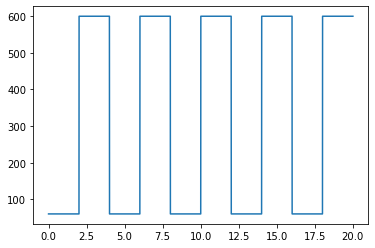

In [57]:
plt.plot(TimeRange,sug_dyn)

In [73]:
#Starting and ending sugars:
sug_start = sug_dyn[0]
# sug_end = 600
# #Sugar as a linear function of time:
# sug_dyn = TimeRange*(sug_end-sug_start)/T + sug_start
#Fitness as a function of the starting sugar:
fit = fitness(g,sug_start,delta)
g_reg = g[np.argmax(fit)]
print(f"g_reg={round(g_reg,2)}")

alpha = 1
delta = 170/g_max

#Generating the initial distributions:
g_peak = 0.5*(g_min+g_max)
#We don't want a standard deviation of 0, so even if the g_reg is 0, we set the s.d. of p0_reg to 1:
p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
# p0_unreg = np.ones_like(g)
# p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1))
p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

g_reg=9.2


In [74]:
# #Now solving the PDE
# p_unreg,p_reg = selection(p0_unreg,p0_reg,sug,alpha,delta)

# #Normalized fitness attained by:
# print("Normalized fitness, without reg, pre-sel: ",\
#     (mean_wrt_P(fitness(g,sug,delta),p0_unreg,g)-np.min(fitness(g,sug,delta)))/(np.max(fitness(g,sug,delta))-np.min(fitness(g,sug,delta))))
# print("Normalized fitness, with reg, pre-sel: ",\
#     (mean_wrt_P(fitness(g,sug,delta),p0_reg,g)-np.min(fitness(g,sug,delta)))/(np.max(fitness(g,sug,delta))-np.min(fitness(g,sug,delta))))
# print("Normalized fitness, without reg, post-sel: ",\
#     (mean_wrt_P(fitness(g,sug,delta),p_unreg,g)-np.min(fitness(g,sug,delta)))/(np.max(fitness(g,sug,delta))-np.min(fitness(g,sug,delta))))
# print("Normalized fitness, with reg, post-sel: ",\
#     (mean_wrt_P(fitness(g,sug,delta),p_reg,g)-np.min(fitness(g,sug,delta)))/(np.max(fitness(g,sug,delta))-np.min(fitness(g,sug,delta))))

Text(0.5, 1.0, 'Sugar vs time')

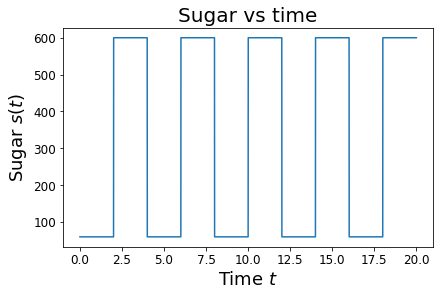

In [75]:
#Visualizing sugar:
fig,ax = plt.subplots(1,1,constrained_layout='true')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.plot(TimeRange,sug_dyn)
ax.set_xlabel(r"Time $t$",fontsize=18)
ax.set_ylabel(r"Sugar $s(t)$",fontsize=18)
ax.set_title("Sugar vs time",fontsize=20)

# fig,ax = plt.subplots(1,1,constrained_layout='true')
# ax.set_xscale('log')
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.scatter(alphas,tot_fit_unreg_sel[:,delta_idx])
# ax.set_xticks(alphas)
# ax.set_xticklabels(np.around(alphas,2))
# ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
# ax.set_ylabel(r"Average fitness",fontsize=18)
# ax.set_title(fr"No reg., after sel. ($\delta$={np.around(deltas[delta_idx],1)})",fontsize=20)
# fig.savefig(f"2a_fit_unreg_sel_vs_alpha_delta={np.around(deltas[delta_idx],1)}.eps", format="eps")

In [76]:
p_unreg, p_reg, dyn_fit_unreg, dyn_fit_reg = selection(p0_unreg,p0_reg,sug_dyn,alpha,delta)

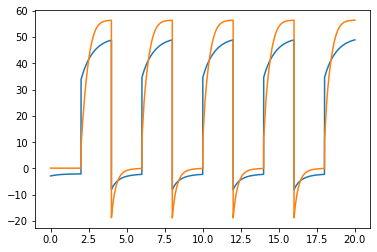

In [77]:
plt.plot(TimeRange,dyn_fit_unreg)
plt.plot(TimeRange,dyn_fit_reg)
